# Exp_9: Build a text classification application by training a neural network in pytorch framework. The dataset should have greater than 3 classes. Test the model and visualize performance metrics. 

# Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

In [5]:
# Create dataset with real-world text noise patterns
raw_data = [
    # Positive class with various noise patterns
    ("I absolutely LOVE this product!!! 😊", "positive"),
    ("amazing quality, highly recommend", "positive"),
    ("Gr8 service, will buy again 👍", "positive"),
    ("best purchase ever made!!!", "positive"),
    ("Excellent customer support... really happy", "positive"),
    ("10/10 would recommend to friends", "positive"),
    ("Super fast delivery & great packaging", "positive"),
    ("Worth every penny spent on this", "positive"),
    ("Quality is top-notch, love it", "positive"),
    ("Outstanding product, exceeded expectations!", "positive"),
    ("Really good value for money spent", "positive"),
    ("Perfect fit, exactly what I needed", "positive"),
    ("Couldn't be happier with purchase", "positive"),
    ("Awesome features, user-friendly design", "positive"),
    ("Five stars ⭐⭐⭐⭐⭐ definitely!", "positive"),

    # Negative class with noise
    ("terrible quality, waste of money :(", "negative"),
    ("WORST product ever bought!!!", "negative"),
    ("poor customer service, very disappointed", "negative"),
    ("broke after 2 days... complete junk", "negative"),
    ("overpriced garbage, don't buy this", "negative"),
    ("horrible experience, requesting refund", "negative"),
    ("cheaply made, falls apart easily", "negative"),
    ("not as described, feels like scam", "negative"),
    ("took forever to arrive & damaged", "negative"),
    ("0/10 stars, completely useless product", "negative"),
    ("regret buying this piece of junk", "negative"),
    ("terrible design, doesn't work properly", "negative"),
    ("waste of time and money honestly", "negative"),
    ("poor quality control, arrived broken", "negative"),
    ("disappointed with overall experience :(", "negative"),

    # Neutral class with noise
    ("it's okay, nothing special though", "neutral"),
    ("average product, meets basic requirements", "neutral"),
    ("decent quality for the price point", "neutral"),
    ("received as expected, no complaints", "neutral"),
    ("standard features, works as intended", "neutral"),
    ("fair price, reasonable quality overall", "neutral"),
    ("arrived on time, packaging was adequate", "neutral"),
    ("does the job, but room for improvement", "neutral"),
    ("acceptable build quality, average performance", "neutral"),
    ("neutral feelings about this purchase", "neutral"),
    ("it's fine, serves its purpose well", "neutral"),
    ("middle-of-the-road product, nothing amazing", "neutral"),
    ("satisfactory experience, met expectations", "neutral"),
    ("regular quality, typical for this price", "neutral"),
    ("okay product, neither good nor bad", "neutral"),

    # Additional noisy samples with typos, abbreviations, mixed case
    ("luv this sm!! gr8 quality 4 the $$$", "positive"),
    ("omg soooo good, cant believe how nice", "positive"),
    ("tbh its pretty gud, would buy agn", "positive"),
    ("HATE IT SO MUCH!!! terrible terrible", "negative"),
    ("ugh... wish i nvr bought this thing", "negative"),
    ("meh... its alright i guess, nothing 2 special", "neutral"),
    ("kinda average tbh, not impressed but ok", "neutral"),
    ("really really really love this product!!!", "positive"),
    ("absolutely terrible experience, never again!!!", "negative"),
]

In [6]:
# Convert to DataFrame
df = pd.DataFrame(raw_data, columns=['text', 'sentiment'])
print(f"Dataset created with {len(df)} samples")
print(f"Class distribution:\n{df['sentiment'].value_counts()}")
print(f"\nFirst 3 samples:")
for i in range(3):
    print(f"  Text: '{df.iloc[i]['text']}'")
    print(f"  Label: {df.iloc[i]['sentiment']}")

Dataset created with 54 samples
Class distribution:
sentiment
positive    19
negative    18
neutral     17
Name: count, dtype: int64

First 3 samples:
  Text: 'I absolutely LOVE this product!!! 😊'
  Label: positive
  Text: 'amazing quality, highly recommend'
  Label: positive
  Text: 'Gr8 service, will buy again 👍'
  Label: positive


In [7]:
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove emojis and special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?]', '', text)

    # Normalize common internet slang and abbreviations
    slang_dict = {
        'gr8': 'great', 'gud': 'good', 'luv': 'love', 'sm': 'so much',
        'tbh': 'to be honest', 'omg': 'oh my god', 'nvr': 'never',
        'agn': 'again', 'u': 'you', 'ur': 'your', 'thru': 'through',
        'w/': 'with', '&': 'and', 'cant': 'cannot', 'wont': 'will not',
        'dont': 'do not', 'im': 'i am', 'ive': 'i have'
    }

    # Apply slang normalization
    words = text.split()
    words = [slang_dict.get(word, word) for word in words]
    text = ' '.join(words)

    # Remove extra whitespace and punctuation repetition
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
    text = re.sub(r'[.]{2,}', '.', text)  # Multiple dots
    text = re.sub(r'[!]{2,}', '!', text)  # Multiple exclamation
    text = re.sub(r'[?]{2,}', '?', text)  # Multiple question marks

    # Tokenize, remove stopwords, and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words
             if word not in stop_words and len(word) > 2]

    return ' '.join(words)

# Apply preprocessing
print("Applying text preprocessing...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

print("Sample preprocessing results:")
for i in range(3):
    print(f"  Original: '{df.iloc[i]['text']}'")
    print(f"  Cleaned:  '{df.iloc[i]['cleaned_text']}'")
    print()

Applying text preprocessing...
Sample preprocessing results:
  Original: 'I absolutely LOVE this product!!! 😊'
  Cleaned:  'absolutely love product!'

  Original: 'amazing quality, highly recommend'
  Cleaned:  'amazing quality, highly recommend'

  Original: 'Gr8 service, will buy again 👍'
  Cleaned:  'great service, buy'



In [9]:
# Encode labels to numerical format
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['sentiment'])

print("Label encoding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} -> {i}")

print(f"\nEncoded labels sample: {df['label_encoded'][:5].tolist()}")

Label encoding mapping:
  negative -> 0
  neutral -> 1
  positive -> 2

Encoded labels sample: [2, 2, 2, 2, 2]


In [10]:
# My cleaned data
X = df['cleaned_text']
y = df['label_encoded']

In [12]:
# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training distribution: {np.bincount(y_train)}")
print(f"Testing distribution: {np.bincount(y_test)}")

Training samples: 37
Testing samples: 17
Training distribution: [12 12 13]
Testing distribution: [6 5 6]


In [13]:
# Vectorize the text
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=1,  # Minimum document frequency
    max_df=0.8  # Maximum document frequency
)

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Feature names sample: {list(vectorizer.get_feature_names_out())[:10]}")

TF-IDF matrix shape: (37, 226)
Vocabulary size: 226
Feature names sample: ['010', '010 stars', '1010', '1010 would', 'absolutely', 'absolutely love', 'absolutely terrible', 'acceptable', 'acceptable build', 'adequate']


In [15]:
# Convert to dense arrays for neural network
X_train_dense = X_train_tfidf.toarray().astype(np.float32)
X_test_dense = X_test_tfidf.toarray().astype(np.float32)

print(f"Dense matrix shape: {X_train_dense.shape}")
print(f"Sample vector (first 10 features): {X_train_dense[0][:10]}")

Dense matrix shape: (37, 226)
Sample vector (first 10 features): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
# PYTORCH DATASET CLASS
class TextDataset(Dataset):
    """Custom PyTorch Dataset for text classification"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = TextDataset(X_train_dense, y_train.values)
test_dataset = TextDataset(X_test_dense, y_test.values)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")
print(f"Sample batch shape: {next(iter(train_loader))[0].shape}")

Training batches: 5
Testing batches: 3
Sample batch shape: torch.Size([8, 226])


In [17]:
# PYTORCH NEURAL NETWORK MODEL
class SentimentClassifier(nn.Module):
    """PyTorch Neural Network for Sentiment Classification"""

    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, hidden_size3=32, num_classes=3, dropout_rate=0.3):
        super(SentimentClassifier, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize network weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass through the network"""
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SentimentClassifier(input_size=X_train_dense.shape[1])
model.to(device)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cuda
Model architecture:
SentimentClassifier(
  (fc1): Linear(in_features=226, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)

Total parameters: 39491


In [18]:
# Training setup
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Training configuration:")
print(f"  Loss function: {criterion}")
print(f"  Optimizer: {optimizer}")
print(f"  Learning rate: 0.001")

Training configuration:
  Loss function: CrossEntropyLoss()
  Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
  Learning rate: 0.001


In [19]:
# Train the model
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def validate_epoch(model, test_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training loop
num_epochs = 100
print(f"Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate (using test set as validation for simplicity)
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print("Training completed!")

Training for 100 epochs...
Epoch [10/100]
  Train Loss: 0.9411, Train Acc: 83.78%
  Val Loss: 1.0322, Val Acc: 47.06%
Epoch [20/100]
  Train Loss: 0.3132, Train Acc: 100.00%
  Val Loss: 0.8019, Val Acc: 47.06%
Epoch [30/100]
  Train Loss: 0.0250, Train Acc: 100.00%
  Val Loss: 0.7946, Val Acc: 52.94%
Epoch [40/100]
  Train Loss: 0.0121, Train Acc: 100.00%
  Val Loss: 0.8361, Val Acc: 58.82%
Epoch [50/100]
  Train Loss: 0.0055, Train Acc: 100.00%
  Val Loss: 0.8759, Val Acc: 58.82%
Epoch [60/100]
  Train Loss: 0.0031, Train Acc: 100.00%
  Val Loss: 0.9206, Val Acc: 58.82%
Epoch [70/100]
  Train Loss: 0.0038, Train Acc: 100.00%
  Val Loss: 0.9604, Val Acc: 58.82%
Epoch [80/100]
  Train Loss: 0.0132, Train Acc: 100.00%
  Val Loss: 0.9958, Val Acc: 52.94%
Epoch [90/100]
  Train Loss: 0.0028, Train Acc: 100.00%
  Val Loss: 1.0476, Val Acc: 58.82%
Epoch [100/100]
  Train Loss: 0.0035, Train Acc: 100.00%
  Val Loss: 1.0684, Val Acc: 58.82%
Training completed!


In [23]:
# EVALUATING MODEL PERFORMANCE
# Get predictions on test set
model.eval()
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_test, all_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
target_names = label_encoder.classes_
print(classification_report(y_test, all_predictions, target_names=target_names))

Test Accuracy: 0.5882

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.50      0.60         6
     neutral       0.56      1.00      0.71         5
    positive       0.50      0.33      0.40         6

    accuracy                           0.59        17
   macro avg       0.60      0.61      0.57        17
weighted avg       0.60      0.59      0.56        17




11. CREATING VISUALIZATIONS...
Computing t-SNE visualization...


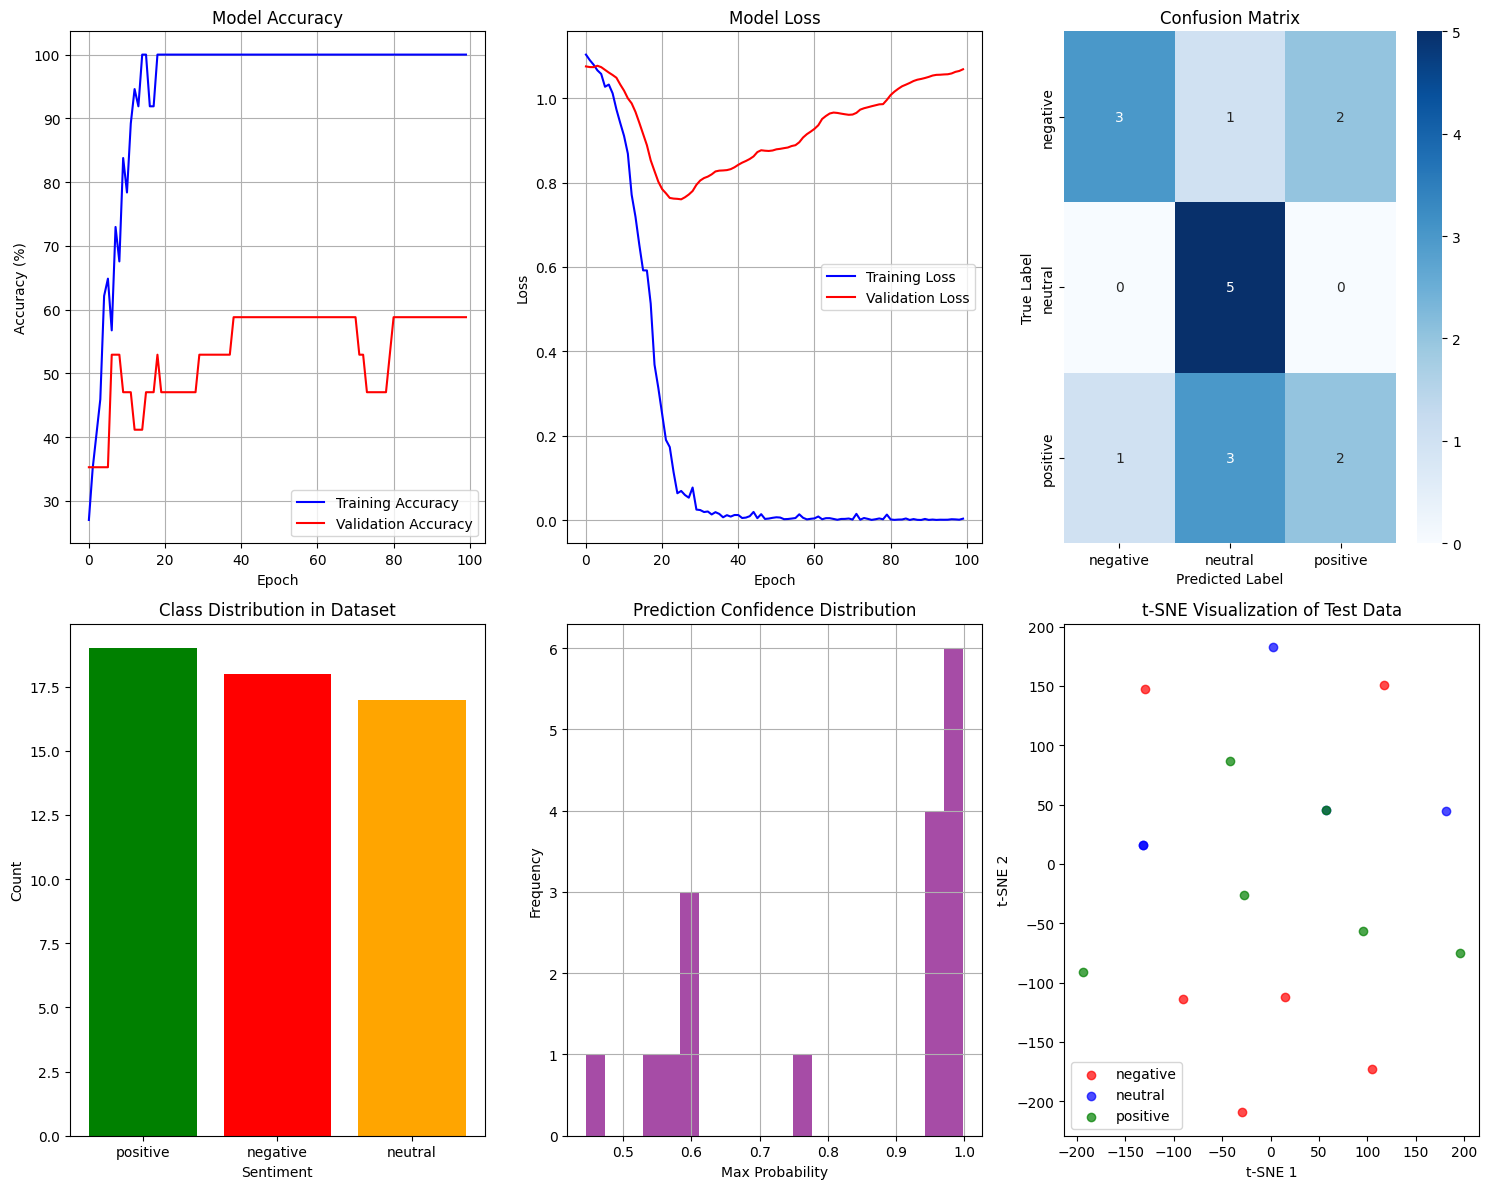

In [24]:
# ============================================================================
# STEP 11: VISUALIZATIONS
# ============================================================================
print("\n11. CREATING VISUALIZATIONS...")

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(15, 12))

# Plot 1: Training History - Accuracy
plt.subplot(2, 3, 1)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot 2: Training History - Loss
plt.subplot(2, 3, 2)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 3: Confusion Matrix
plt.subplot(2, 3, 3)
cm = confusion_matrix(y_test, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot 4: Class Distribution
plt.subplot(2, 3, 4)
class_counts = df['sentiment'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['green', 'red', 'orange'])
plt.title('Class Distribution in Dataset')
plt.ylabel('Count')
plt.xlabel('Sentiment')

# Plot 5: Prediction Confidence
plt.subplot(2, 3, 5)
max_proba = np.max(all_probabilities, axis=1)
plt.hist(max_proba, bins=20, alpha=0.7, color='purple')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Max Probability')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 6: t-SNE Visualization
plt.subplot(2, 3, 6)
print("Computing t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test_dense)-1))
X_tsne = tsne.fit_transform(X_test_dense)

colors = ['red', 'blue', 'green']
for i, sentiment in enumerate(target_names):
    mask = y_test.values == i
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
               c=colors[i], label=sentiment, alpha=0.7)
plt.title('t-SNE Visualization of Test Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:

# ============================================================================
# STEP 12: INTERACTIVE INFERENCE
# ============================================================================
print("\n12. INTERACTIVE INFERENCE SYSTEM")
print("="*50)

def predict_sentiment(text):
    """Predict sentiment for new text using PyTorch model"""
    # Preprocess the text
    cleaned_text = preprocess_text(text)

    # Vectorize
    text_tfidf = vectorizer.transform([cleaned_text])
    text_dense = text_tfidf.toarray().astype(np.float32)

    # Convert to PyTorch tensor
    text_tensor = torch.FloatTensor(text_dense).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(text_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1)

    # Convert back to numpy
    probabilities = probabilities.cpu().numpy()[0]
    predicted_class = predicted_class.cpu().numpy()[0]
    confidence = np.max(probabilities)

    sentiment = label_encoder.inverse_transform([predicted_class])[0]

    return sentiment, confidence, probabilities

# Test with sample texts
test_texts = [
    "This is absolutely amazing! I love it so much!",
    "Terrible product, complete waste of money",
    "It's okay, nothing special but does the job",
    "OMG this is sooo good!!! 😍",
    "meh... its alright i guess"
]

print("Testing PyTorch inference on sample texts:")
print("-" * 50)

for text in test_texts:
    sentiment, confidence, probabilities = predict_sentiment(text)

    print(f"Text: '{text}'")
    print(f"Predicted Sentiment: {sentiment.upper()}")
    print(f"Confidence: {confidence:.3f}")
    print("Class Probabilities:")
    for i, class_name in enumerate(target_names):
        print(f"  {class_name}: {probabilities[i]:.3f}")
    print("-" * 50)

# ============================================================================
# STEP 13: COMMAND LINE INTERFACE
# ============================================================================
print("\n13. PYTORCH COMMAND LINE INTERFACE")
print("="*50)
print("Enter text to classify (type 'quit' to exit):")

while True:
    user_input = input("\nEnter text: ").strip()

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("Goodbye!")
        break

    if not user_input:
        print("Please enter some text.")
        continue

    try:
        sentiment, confidence, probabilities = predict_sentiment(user_input)

        print(f"\n🚀 PYTORCH PREDICTION RESULTS:")
        print(f"Text: '{user_input}'")
        print(f"Predicted Sentiment: {sentiment.upper()}")
        print(f"Confidence: {confidence:.1%}")
        print("\n📈 Detailed Probabilities:")
        for i, class_name in enumerate(target_names):
            bar = "█" * int(probabilities[i] * 20)
            print(f"  {class_name:8}: {probabilities[i]:.1%} {bar}")

        # Interpretation
        if confidence > 0.8:
            print("🔥 High confidence prediction!")
        elif confidence > 0.6:
            print("✅ Moderate confidence prediction")
        else:
            print("⚠️  Low confidence - text might be ambiguous")

    except Exception as e:
        print(f"Error processing text: {e}")

print("\n" + "="*60)
print("PYTORCH NLP PIPELINE COMPLETED SUCCESSFULLY!")
print(f"Final model saved to device: {device}")
print("="*60)


12. INTERACTIVE INFERENCE SYSTEM
Testing PyTorch inference on sample texts:
--------------------------------------------------
Text: 'This is absolutely amazing! I love it so much!'
Predicted Sentiment: POSITIVE
Confidence: 0.968
Class Probabilities:
  negative: 0.032
  neutral: 0.000
  positive: 0.968
--------------------------------------------------
Text: 'Terrible product, complete waste of money'
Predicted Sentiment: NEGATIVE
Confidence: 1.000
Class Probabilities:
  negative: 1.000
  neutral: 0.000
  positive: 0.000
--------------------------------------------------
Text: 'It's okay, nothing special but does the job'
Predicted Sentiment: NEUTRAL
Confidence: 1.000
Class Probabilities:
  negative: 0.000
  neutral: 1.000
  positive: 0.000
--------------------------------------------------
Text: 'OMG this is sooo good!!! 😍'
Predicted Sentiment: NEUTRAL
Confidence: 0.970
Class Probabilities:
  negative: 0.005
  neutral: 0.970
  positive: 0.025
-----------------------------------------


Enter text:  what a waste product



🚀 PYTORCH PREDICTION RESULTS:
Text: 'what a waste product'
Predicted Sentiment: NEGATIVE
Confidence: 99.5%

📈 Detailed Probabilities:
  negative: 99.5% ███████████████████
  neutral : 0.2% 
  positive: 0.3% 
🔥 High confidence prediction!



Enter text:  very good product



🚀 PYTORCH PREDICTION RESULTS:
Text: 'very good product'
Predicted Sentiment: NEUTRAL
Confidence: 79.8%

📈 Detailed Probabilities:
  negative: 14.7% ██
  neutral : 79.8% ███████████████
  positive: 5.5% █
✅ Moderate confidence prediction



Enter text:  good product but service is bad



🚀 PYTORCH PREDICTION RESULTS:
Text: 'good product but service is bad'
Predicted Sentiment: NEUTRAL
Confidence: 91.4%

📈 Detailed Probabilities:
  negative: 6.0% █
  neutral : 91.4% ██████████████████
  positive: 2.6% 
🔥 High confidence prediction!



Enter text:  quit


Goodbye!

PYTORCH NLP PIPELINE COMPLETED SUCCESSFULLY!
Final model saved to device: cuda


# Use AG_NEWS and SST2 (Stanford Sentiment Treebank) and apply the above code to perform text classification. Show the network improves its accuracy to more than 80%. Generate an interference to test the model with prompts.